# Imports and data

In [1]:




import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache3/cache")
set_global("dataloader_workers", 32)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")
import random

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, dict2sampleList, run_simclr, load_stored_params
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, HalfSwap, get_transforms_for_bbox_methods
from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset, ImageFolderDataset, ZipDatasets
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
from facebook_hateful_memes_detector.utils import get_vgg_face_model, get_torchvision_classification_models, init_fc, my_collate, merge_sample_lists
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


scheduler_init_fn = get_cosine_schedule_with_warmup()
scheduler_init_fn = get_constant_schedule_with_warmup()
# Use mixup in SSL training, Use UDA maybe


In [2]:

sep = " [SEP] "
add_objects_and_caption = False
from collections import defaultdict
obcp = pd.read_csv("/home/ahemf/cache/data/objects_captions.csv").values
object_captions = defaultdict(dict)
for d in obcp:
    object_captions[d[0]]["objects"] = d[1]
    object_captions[d[0]]["caption"] = d[2]
    


In [3]:
def get_preprocess_text():
    char_level = {
        "keyboard": 0.1,
        "char_substitute": 0.4,
        "char_insert": 0.2,
        "char_swap": 0.2,
        "ocr": 0.0,
        "char_delete": 0.1,
        "vowel_replace": 0.75
    }
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {
        "split": 0.2,
        "stopword_insert": 0.0,
        "word_join": 0.2,
        "word_cutout": 0.25,
    }
    word_level = TextAugment([0.1, 0.8, 0.1], word_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    sentence_level = {
        "one_third_cut": 0.25,
        "part_select": 0.25,
        "glove_twitter": 0.75,
        
    }
    sentence_level = TextAugment([0.0, 1.0], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    gibberish = {
        "gibberish_insert": 0.25,
        "punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, 
        "punctuation_continue": 0.5
    }
    gibberish = TextAugment([0.75, 0.25], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/hard_dab.csv")
    

    def process(text, **kwargs):
        identifier = kwargs["identifier"]
        ptext = text
        rng = random.random()
        if rng < 0.1:
            return text
        elif rng < 0.4:
            text = sentence_level(text, **kwargs)
            text = word_level(text, **kwargs)
        elif rng < 0.7:
            text = word_level(text, **kwargs)
            text = char_level(text, **kwargs)
            text = gibberish(text, **kwargs)
        else:
            text = translation(text, **kwargs)
        if text == ptext:
            text = sentence_level(text, **kwargs)
            text = word_level(text, **kwargs)
        if random.random() < 0.25:
            caption = str(object_captions[identifier]["caption"])
            objects = str(object_captions[identifier]["objects"])
            if random.random() < 0.5:
                caption = sentence_level(caption, **kwargs)
                objects = sentence_level(objects, **kwargs)
            text = text + sep + caption + sep + objects
        return text

    return process


preprocess_text = get_preprocess_text()
transforms_for_bbox_methods = get_transforms_for_bbox_methods()


data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=preprocess_text,
                    train_image_transform=get_transforms_for_bbox_methods(),
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)



data["test"]["label"] = -1
data['test_unseen']["label"] = -1
dev_unseen = data['dev_unseen'].copy()
dev_unseen["label"] = -1
test_seen = data["test"]
test_unseen = data['test_unseen']
test_seen = test_seen[~test_seen["id"].isin(set(test_unseen["id"]))]
test_seen.shape

df = pd.concat((data["train"],
                dev_unseen,
                data["test"], data['test_unseen']))
df.shape


(1000, 4)

(12140, 4)

In [4]:
dataset = convert_dataframe_to_dataset(df, data["metadata"], True)

In [5]:
# MLM for TextImage, AugSim for All

# data = get_datasets(data_dir="../data/",
#                     train_text_transform=None,
#                     train_image_transform=None,
#                     test_text_transform=None,
#                     test_image_transform=None,
#                     train_torchvision_image_transform=None,
#                     test_torchvision_image_transform=None,
#                     train_torchvision_pre_image_transform=None,
#                     test_torchvision_pre_image_transform=None,
#                     cache_images=True,
#                     use_images=True,
#                     dev=False,
#                     test_dev=True,
#                     keep_original_text=True,
#                     keep_original_image=True,
#                     keep_processed_image=True,
#                     keep_torchvision_image=False,
#                     train_mixup_config=dict(proba=0.0))
# dataset = convert_dataframe_to_dataset(df, data["metadata"], True)



In [6]:
vectorized_text_processor = np.vectorize(preprocess_text)

def torch_vectorize(fn):
    def vfn(elements):
        elements = [fn(e) for e in elements]
        return torch.stack(elements)# .type(torch.cuda.HalfTensor)
    return vfn
from facebook_hateful_memes_detector.preprocessing import get_image_transforms_pytorch
preprocess = transforms.Compose([
    get_image_transforms_pytorch(mode="hard"),
    get_image2torchvision_transforms(),
])
preprocess_torchvision_image = torch_vectorize(preprocess)

def vectorized_image_processor(images):
    return [transforms_for_bbox_methods(i) for i in images]

def augment_method(sampleList):
    sampleList = dict2sampleList(sampleList)
    sampleList = sampleList.copy()
    if "torchvision_image" in sampleList:
        sampleList.torchvision_image = preprocess_torchvision_image(sampleList.original_image)
    sampleList.image = vectorized_image_processor(sampleList.original_image)
    sampleList.text = vectorized_text_processor(sampleList.original_text)
    sampleList.mixup = [False] * len(sampleList.text)
    sampleList = sampleList.to(get_device())
    return sampleList


In [7]:
model_params = dict(
    model_name={"lxmert": dict(dropout=0.05, gaussian_noise=0.01)},
    num_classes=2,
    gaussian_noise=0.0,
    dropout=0.0,
    word_masking_proba=0.15,
    featurizer="pass",
    final_layer_builder=fb_1d_loss_builder,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=160,
    n_tokens_out=160,
    n_layers=0,
    attention_drop_proba=0.0,
    loss="focal",
    bbox_swaps=1,
    bbox_copies=1,
    bbox_gaussian_noise=0.01,
    bbox_feature_dropout=0.01,
    bbox_dropout=0.01,
    finetune=False)

model_class = VilBertVisualBertModel
model = model_class(**model_params)
model = model.to(get_device())



LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.


Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  196 Classifier Dims =  768 Matches embedding_dims:  True


# Unimodal MLM

In [8]:



from facebook_hateful_memes_detector.utils import MLMPretraining
mlm_model = MLMPretraining(model, model.text_processor._tokenizer, 768, "relu", 160)
mlm_model = mlm_model.to(get_device())

mlm_model.load_state_dict(torch.load("lxmert-mlm-init.pth"))


<All keys matched successfully>

In [ ]:

clean_memory()
lr_strategy = {
    "model": {
        "finetune": False,
    },
    "mlm": {
        "finetune": True
    }
}
epochs = 2
batch_size = 64
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)



_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates, _ = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)



mlm_model.plot_loss_acc_hist()
mlm_model.test_accuracy(batch_size, dataset)




In [12]:
torch.save(mlm_model.state_dict(), "lxmert-mlm-init.pth")



In [13]:
clean_memory()

In [ ]:

clean_memory()
epochs = 5
batch_size = 32
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=4e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)

lr_strategy = {
    "model": {
        "finetune": True,
    },
    "mlm": {
        "finetune": True
    }
}

_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates, _ = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=2, plot=True,
                                     sampling_policy=None, class_weights=None)



mlm_model.plot_loss_acc_hist()
acc = mlm_model.test_accuracy(batch_size, dataset)


Autocast =  True Epochs =  5 Divisor = 1 Examples = 12140 Batch Size =  32
Training Samples =  12140 Weighted Sampling =  False Num Batches =  380 Accumulation steps =  2


Exception for:  keyboard | [Original Text]: do you see him? i don't see [Final Text]: do you see him? i don't see 
[Augs]: ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  1 Loss = 0.322738 LR = 0.00002667


Exception for:  keyboard | [Original Text]: okay now make sure to get my side [Final Text]:  * kay n*w mak* s*re t* get my s*de 
[Augs]: ['vowel_replace' 'keyboard'] argument of type 'NoneType' is not iterable
Exception for:  keyboard | [Original Text]: 50% off [Final Text]: 50% off 
[Augs]: ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  2 Loss = 0.309747 LR = 0.00004000


Exception for:  keyboard | [Original Text]: who let the out ! [Final Text]: who let the out ! 
[Augs]: ['keyboard'] argument of type 'NoneType' is not iterable


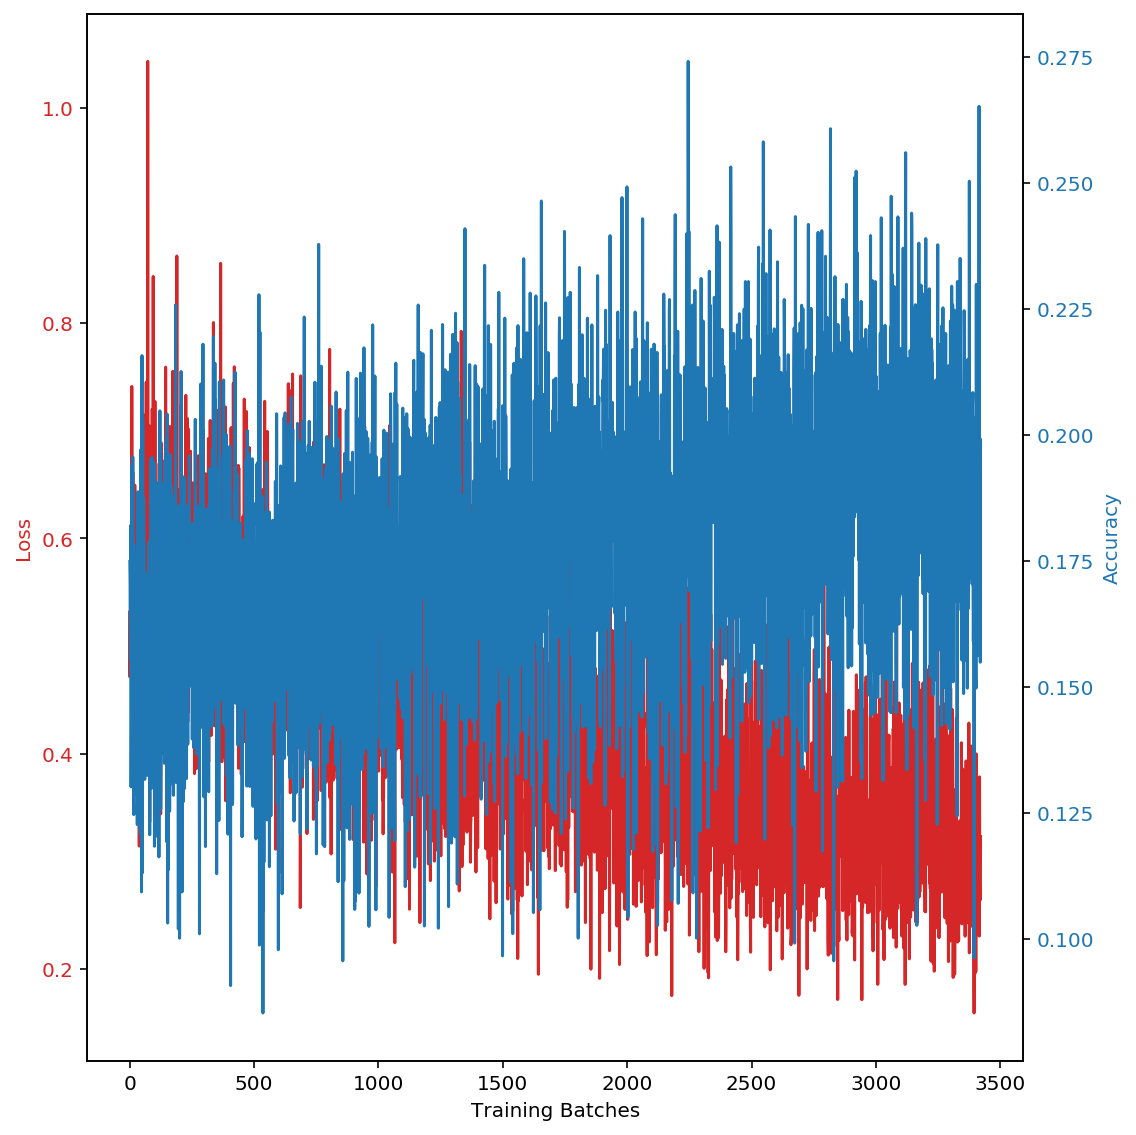

In [11]:
mlm_model.plot_loss_acc_hist()

In [ ]:
acc = mlm_model.test_accuracy(batch_size, dataset)

In [ ]:
torch.save(mlm_model.model.state_dict(), "lxmert-mlm.pth")


# AugSim
- Combine both unimodal and bimodal augsim using `random.random`
- Take hints from SimCLR
- We can do Text x Image (TODO: CrissCrossDataset for Augsim)


In [ ]:
load_stored_params(model, "lxmert-mlm.pth")
set_global("cache_allow_writes", True)


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params


In [ ]:
epochs = 10
batch_size = 64


_ = group_wise_finetune(model, lr_strategy_model)
params_conf, _ = group_wise_lr(model, lr_strategy_model)
optim = optimizer_class(params_conf, **optimizer_params)

_ = train_for_augment_similarity(model,
                                 optim,
                                 scheduler_init_fn,
                                 batch_size,
                                 epochs,
                                 dataset,
                                 augment_method=augment_method,
                                 model_call_back=None,
                                 collate_fn=my_collate,
                                 accumulation_steps=4,
                                 plot=True)
# 0.001580, 0.000527
# Try Augsim with L2 normed / LayerNormed vectors


In [ ]:
torch.save(model.state_dict(), "lxmert-augsim.pth")
# model.load_state_dict(torch.load("lxmert-augsim.pth"))

# SimCLR style or Differentiator
- Combine Unimodal and Bimodal with probability
- In unimodal differentiator we only change either text or image
- Ability to use non-overlapping image sections.


In [ ]:
load_stored_params(model, "lxmert-smclr.pth")


In [ ]:
from facebook_hateful_memes_detector.utils import SimCLR

def simclr_aug(sampleList):
    sampleList = augment_method(sampleList.copy())
    s2 = sampleList.copy()
    s2.text = list(reversed(s2.text))
    s = merge_sample_lists(sampleList, s2)
    return s

# set_global("cache_allow_writes", False)


In [ ]:
smclr = SimCLR(model, 768, 256, 0.05, simclr_aug, simclr_aug)
smclr = smclr.to(get_device())

lr_strategy_pre = {
    "finetune": True,
    "model": {
        "finetune": False,
    },
}

lr_strategy_post = {
    "finetune": True,
}

pre_lr, post_lr = 5e-5, 5e-5
pre_batch_size, post_batch_size = 256, 32
pre_epochs, full_epochs = 2, 5
collate_fn = my_collate

def simclr_aug(sampleList):
    sampleList = augment_method(sampleList.copy())


In [ ]:
res = run_simclr(smclr, dataset, dataset, lr_strategy_pre, lr_strategy_post, pre_lr, post_lr,
           pre_batch_size, post_batch_size, pre_epochs, full_epochs,
           collate_fn)

res

# 0.3268


In [ ]:
torch.save(model.state_dict(), "lxmert-smclr.pth")